In [1]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
# import tensorflow_io as tfio
from tensorflow.python.client import device_lib

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Initializing the InceptionResNetV2

In [2]:
resnet2 = InceptionResNetV2(weights='imagenet')

225222656/225209952 [==============================] - 5s 0us/step


In [3]:
resnet = InceptionResNetV2(weights='imagenet', input_shape=(299,299,3),include_top=False)

219070464/219055592 [==============================] - 1s 0us/step


In [4]:
resnet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 149, 149, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                               

In [5]:
resnet2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [14]:
img = imread('/content/test5.jpg')

In [15]:
img.shape

(408, 612, 3)

In [16]:
rimg = resize(img, output_shape=(299,299), mode='constant')

In [17]:
rimg.shape

(299, 299, 3)

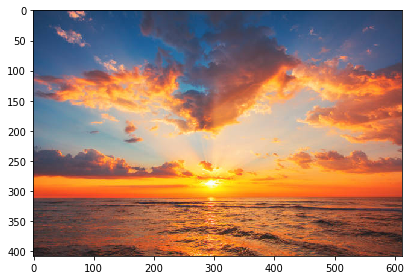

In [18]:
imshow(img)

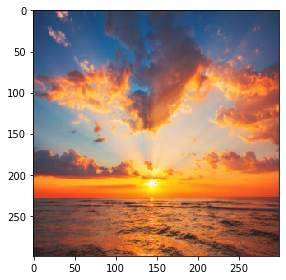

In [19]:
imshow(rimg)

In [20]:
x=rgb2lab(img)

In [21]:
x.shape

(408, 612, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


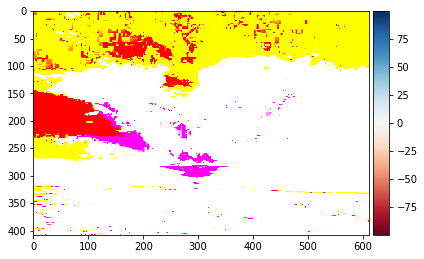

In [22]:
imshow(x)

In [23]:
l = x[:,:,0]

In [24]:
l.shape

(408, 612)

In [25]:
z= gray2rgb(rgb2gray(l))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """Entry point for launching an IPython kernel.


In [26]:
z.shape

(408, 612, 3)

In [27]:
p=resize(z, (299,299,3))

In [28]:
p.shape

(299, 299, 3)

In [29]:
r = []
r.append(rimg)
r = np.asarray(r)

In [30]:
r.shape

(1, 299, 299, 3)

In [35]:
embedded = resnet2.predict(r)

In [36]:
embedded.shape

(1, 1000)

In [37]:
encoder_output = np.random.randint(0,100,size=(32,32,256))

In [38]:
encoder_output.shape

(32, 32, 256)

In [39]:
encoder_output = encoder_output / 255

In [40]:
encoder_output = encoder_output.reshape((1,)+encoder_output.shape)

In [41]:
encoder_output.shape

(1, 32, 32, 256)

In [46]:
fusion_output = RepeatVector(32 * 32)(embedded)
fusion_output2 = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output3 = concatenate([encoder_output, fusion_output2], axis=3)
fusion_output4 = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output3)

In [47]:
fusion_output.shape

TensorShape([1, 1024, 1000])

In [48]:
fusion_output2.shape

TensorShape([1, 32, 32, 1000])

In [49]:
fusion_output3.shape

TensorShape([1, 32, 32, 1256])

In [52]:
fusion_output4.shape

TensorShape([1, 32, 32, 256])

In [ ]:
fusion_output4

In [ ]:
encoder_output

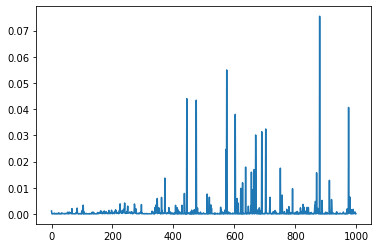

In [ ]:
plt.plot(embedded.ravel())

In [ ]:
np.max(embedded.ravel())

0.07545516

In [ ]:
embedded[0]